In [8]:
import os
import frgtools.misc as frgm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from matplotlib import style
mpl.rcParams.update(mpl.rcParamsDefault)
import cv2
import re
import frgtools.plotting as frgplt
import skimage.filters as filters
import skimage.restoration as restoration
import skimage.feature as feature
import skimage.morphology as morphology
import skimage.segmentation as segmentation
import skimage.measure as measure
from scipy import ndimage as ndi
import pandas as pd
import seaborn as sns
from PIL import Image



In [2]:
from importlib import reload
reload(frgm)

<module 'frgtools.misc' from '/Users/deniz/Documents/GitHub/Python-Utilities/FrgTools/frgtools/misc.py'>

In [3]:
from scipy.stats import mode
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'


In [4]:
def extractPixelSize(fid, plot = False):
    d = np.array(Image.open(fid))
    scale = 111600.0
    corner = (730, 900)
    value = 36
    textmask = d[corner[0]-30:corner[0], corner[1]:corner[1]+120] == value
    text = pytesseract.image_to_string(textmask).split(' ')
    try:
        num = float(text[0])
    except:
        print('Error extracting pixel size for {}'.format(fid))
        return None
    
    if 'K' in text[1]:
        num*=1000
    
    if plot:
        print(text)
        plt.imshow(textmask)
        plt.show()
    return scale/num

In [5]:
def getPerimiters(img, rois, sigma = 2, color = [1,1,1,1]):
    perim = np.full(img.shape, False)
    for r in rois:
#         edgemask = feature.canny(r.intensity_image, sigma = sigma)
        binary_eroded = morphology.erosion(r.filled_image, selem = morphology.disk(sigma))
        edgemask = r.filled_image ^ binary_eroded
        m0, n0, m1, n1 = r.bbox
        perim[m0:m1, n0:n1] += edgemask
    perim[perim > 1] = 1
#     perim[perim == 0] = np.nan
#     perim = perim.astype(np.float32)
    
    colorperim = np.zeros((img.shape[0], img.shape[1], 4))
    colorperim[perim] = color
    return colorperim
    

## Process Data

In [7]:
datadirs = frgm.listdir('/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8', display = True)

Files in '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8':
0:A_00.tif
1:A_01.tif
2:A_02.tif
3:B_00.tif
4:B_01.tif
5:B_02.tif
6:B_03.tif
7:B_04.tif
8:C_00.tif
9:C_01.tif
10:C_02.tif
11:C_03.tif
12:D_00.tif
13:D_01.tif
14:D_02.tif
15:D_03.tif


In [29]:
datadirs[1]

'/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/A_01.tif'

In [31]:
dfData = {l:[] for l in ['imgpath']}
for f1 in range(len(datadirs)):
    dfData['imgpath'].append(datadirs[f1])
#     if os.path.isdir(f1): 
# #         thickness = float(os.path.basename(f1).split('nm')[0])
#         for f2 in frgm.listdir(f1, find = 'tif'):
#                     dfData['imgpath'].append(f2)

In [32]:
dfData

{'imgpath': ['/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/A_00.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/A_01.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/A_02.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/B_00.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/B_01.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/B_02.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/B_03.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/B_04.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/C_00.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8/C_01.tif',
  '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210212_T8

In [33]:
df = pd.DataFrame(dfData)

In [36]:
df

imgpath
0   /Volumes/GoogleDrive/My Drive/Characterization...
1   /Volumes/GoogleDrive/My Drive/Characterization...
2   /Volumes/GoogleDrive/My Drive/Characterization...
3   /Volumes/GoogleDrive/My Drive/Characterization...
4   /Volumes/GoogleDrive/My Drive/Characterization...
5   /Volumes/GoogleDrive/My Drive/Characterization...
6   /Volumes/GoogleDrive/My Drive/Characterization...
7   /Volumes/GoogleDrive/My Drive/Characterization...
8   /Volumes/GoogleDrive/My Drive/Characterization...
9   /Volumes/GoogleDrive/My Drive/Characterization...
10  /Volumes/GoogleDrive/My Drive/Characterization...
11  /Volumes/GoogleDrive/My Drive/Characterization...
12  /Volumes/GoogleDrive/My Drive/Characterization...
13  /Volumes/GoogleDrive/My Drive/Characterization...
14  /Volumes/GoogleDrive/My Drive/Characterization...
15  /Volumes/GoogleDrive/My Drive/Characterization...

In [34]:
df.head()

imgpath
0  /Volumes/GoogleDrive/My Drive/Characterization...
1  /Volumes/GoogleDrive/My Drive/Characterization...
2  /Volumes/GoogleDrive/My Drive/Characterization...
3  /Volumes/GoogleDrive/My Drive/Characterization...
4  /Volumes/GoogleDrive/My Drive/Characterization...

In [38]:
df['scale'] = df['imgpath'].apply(extractPixelSize)

TypeError: Cannot handle this data type: (1, 1, 3), |b1

In [43]:
df['scale'].fillna(2.233, inplace = True)

Manual Scale for failed image reads

In [44]:
idx = df[df['imgpath'].str.contains('40nm-12.tif')].index[0]
df['scale'].iat[idx] = 1.478

In [45]:
idx = df[df['imgpath'].str.contains('30nm-after-33.tif')].index[0]
df['scale'].iat[idx] = 55.82

In [46]:
idx = df[df['imgpath'].str.contains('30nm-after-34.tif')].index[0]
df['scale'].iat[idx] = 1.105

In [47]:
idx = df[df['imgpath'].str.contains('20nm_05.tif')].index[0]
df['scale'].iat[idx] = 11.05

In [44]:
df['mag'] = np.round(111600 / df['scale'], -2)

In [48]:
df = df[df['scale'] < 3] #drop zoomed out images, images with scale extraction issues

In [35]:
df['img'] = df['imgpath'].apply(lambda x: np.array(Image.open(x))[:700, :])

In [50]:
def before_or_after(fid):
    if 'after' in fid:
        return True
    else:
        return False
df['after_electrolysis'] = df['subfolder'].apply(before_or_after)

C:\Users\RishiKumar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
def get_extent(row):
    vsize, hsize = row['img'].shape
    return [0, hsize*row['scale'], 0, vsize*row['scale']]
df['extent'] = df.apply(get_extent, axis = 1)

In [52]:
import re

df['sample'] = df.apply(lambda r: '{}_{}'.format(int(r['thickness']), re.findall('sample(.\d*)', r['subfolder'])[0]), axis = 1)

C:\Users\RishiKumar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Batch Thresholding

In [89]:
def threshold_sem(img0):
    img = ndi.median_filter(img0, 9)
    thresh = filters.threshold_niblack(img, window_size = 71, k = 0)
    mask = img > thresh
    
    distance = ndi.distance_transform_edt(mask)
    distance = filters.gaussian(distance, sigma = 1)
    local_maxima = feature.peak_local_max(distance, indices = False, footprint = morphology.disk(5), min_distance = 15)#[49:-49, 49:-49]

    #watershed
    markers = ndi.label(local_maxima)[0]
    roi_labels = segmentation.watershed(-img, markers = markers, mask = mask)
    rois = [r for r in measure.regionprops(roi_labels) if r['area'] > 10]
    
    return rois

df['rois'] = df['img'].apply(threshold_sem)

In [90]:
df['boundaries'] = df.apply(lambda r: getPerimiters(r['img'], r['rois'], sigma = 2, color = [1,0,0,1]), axis = 1)

In [39]:
df.to_hdf('20200907_EpiCu_PostAnnealSEMSegmentation.h5', key = 'images', mode = 'w')

C:\Users\RishiKumar\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['subfolder', 'imgpath', 'img', 'extent', 'rois', 'boundaries']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [ ]:
# df = pd.read_hdf('20200401_EpiCu_SEMSegmentation.h5', key = 'rek')

## View segmentations

In [40]:
df.columns

Index(['thickness', 'subfolder', 'imgpath', 'scale', 'mag', 'img', 'extent',
       'rois', 'boundaries'],
      dtype='object')

In [28]:
dfsel.shape

(31, 10)

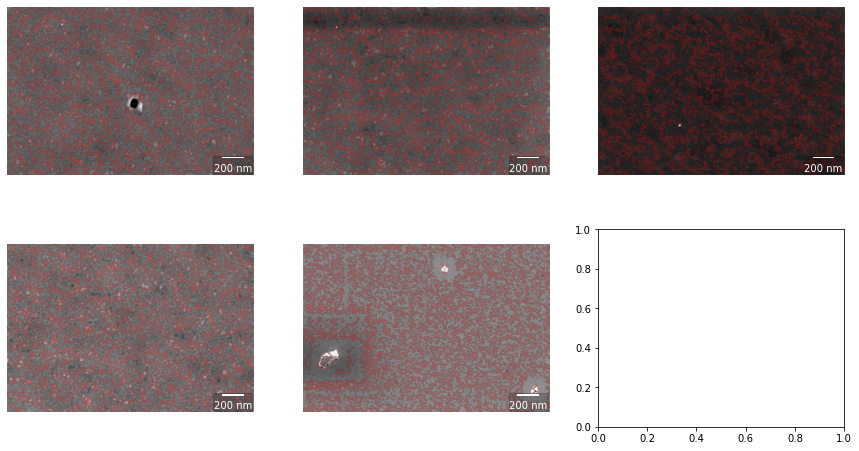

In [49]:
dfsel = df[
#     (df['thickness'] == 20)
    (df['mag'] == 5e4)
]
cols = np.ceil(np.sqrt(dfsel.shape[0])).astype(np.uint8)
rows = np.ceil(dfsel.shape[0]/cols).astype(np.uint8)

fig, ax = plt.subplots(rows, cols ,figsize = (cols*5,rows*4))
for ax_, (_, r) in zip(ax.ravel(), dfsel.iterrows()):
    ax_.imshow(r['img'], cmap = plt.cm.gray)
    ax_.imshow(r['boundaries'], alpha = 0.5)
#     ax_.set_title(r['sample'])
    ax_.axis('off')
    frgplt.scalebar(scale = r['scale']*1e-9, ax = ax_)

# plt.savefig('20200401_Segmentations', dpi = 200, bbox_inches = 'tight')
plt.show()

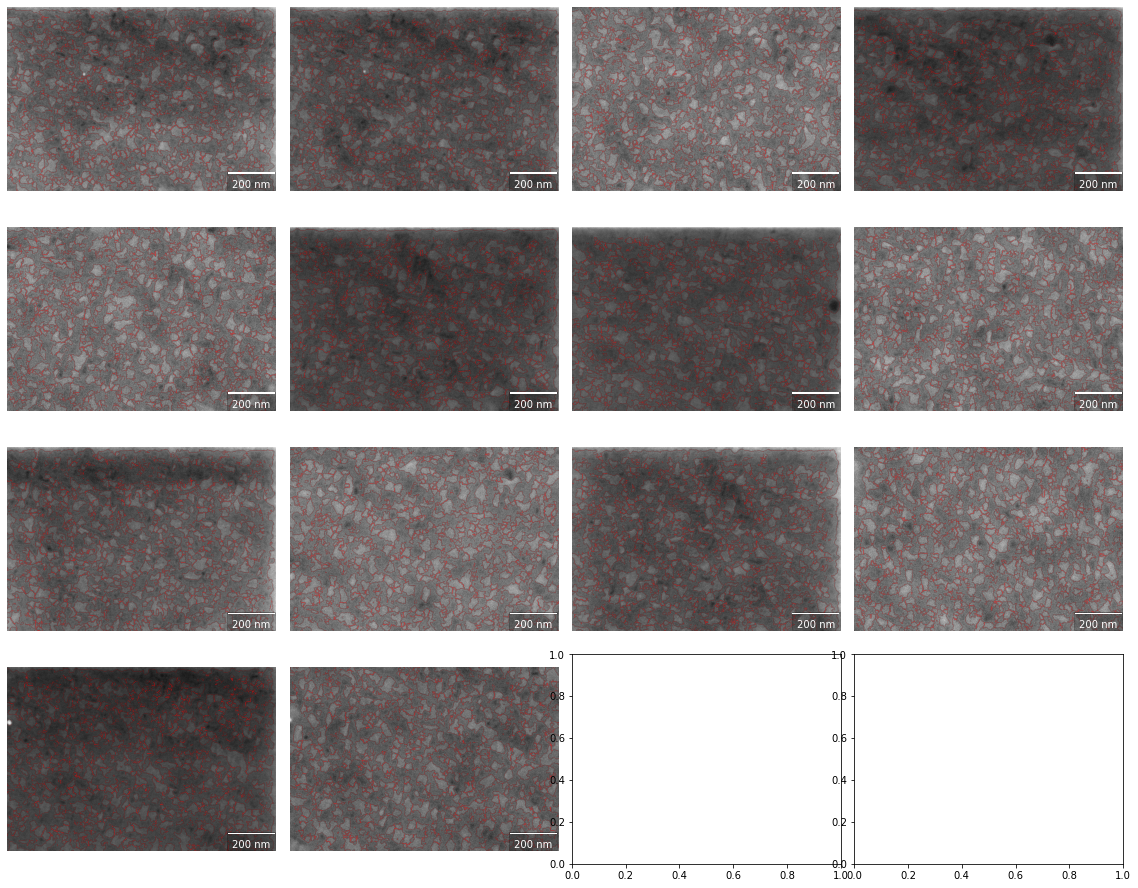

In [91]:
dfsel = df[
#     (df['thickness'] == 20)
    (df['mag'] == 1e5)
]
cols = np.ceil(np.sqrt(dfsel.shape[0])).astype(np.uint8)
rows = np.ceil(dfsel.shape[0]/cols).astype(np.uint8)

fig, ax = plt.subplots(rows, cols ,figsize = (cols*5,rows*4))
plt.subplots_adjust(hspace = 0.05, wspace = 0.05)
for ax_, (_, r) in zip(ax.ravel(), dfsel.iterrows()):
    ax_.imshow(r['img'], cmap = plt.cm.gray)
    ax_.imshow(r['boundaries'], alpha = 0.5)
#     ax_.set_title(r['sample'])
    ax_.axis('off')
    frgplt.scalebar(scale = r['scale']*1e-9, ax = ax_)

plt.savefig('20200907_PostAnnealSegmentations_medfilt9', dpi = 200, bbox_inches = 'tight')
plt.show()

## Roi-wise dataframe

In [92]:
sampleroi = df['rois'].values[0][0]
roikeys = [k for k in dir(sampleroi) if not k.startswith('_')]
roikeys.remove('intensity_image')
dfkeys = ['scale']
roi_dfData = {l:[] for l in dfkeys + roikeys}

for _, row in df.iterrows():
    for roi in row['rois']:
        for k in dfkeys:
            roi_dfData[k].append(row[k])
        for k in roikeys:
            try:
                roi_dfData[k].append(roi[k])
            except:
                roi_dfData[k].append(np.nan)

roidf = pd.DataFrame(roi_dfData)

In [93]:
roidf.shape

(17702, 38)

In [63]:
roidf.head()

scale  area                bbox  bbox_area  \
0  1.116  2883   (0, 431, 24, 652)       5304   
1  1.116    14   (7, 652, 11, 658)         24   
2  1.116   885   (0, 648, 22, 733)       1870   
3  1.116  4338  (0, 731, 99, 1024)      29007   
4  1.116  2129   (0, 276, 32, 433)       5024   

                                  centroid  convex_area  \
0   (7.355532431494971, 538.1054457162678)         4857   
1   (8.428571428571429, 654.5714285714286)           18   
2   (5.855367231638418, 694.6338983050847)         1510   
3  (16.252189949285384, 908.0578607653297)        16437   
4    (8.14044152184124, 358.5645843118835)         3511   

                                        convex_image  \
0  [[False, False, True, True, True, True, True, ...   
1  [[False, True, True, True, True, False], [True...   
2  [[False, False, True, True, True, True, True, ...   
3  [[False, False, True, True, True, True, True, ...   
4  [[False, False, False, False, True, True, True...   

                                              coords  eccentricity  \
0  [[0, 433], [0, 434], [0, 435], [0, 436], [0, 4...      0.996187   
1  [[7, 654], [7, 655], [7, 656], [8, 652], [8, 6...      0.709213   
2  [[0, 650], [0, 651], [0, 652], [0, 653], [0, 6...      0.982714   
3  [[0, 733], [0, 734], [0, 736], [0, 737], [0, 7...      0.978367   
4  [[0, 280], [0, 281], [0, 282], [0, 283], [0, 2...      0.988199   

   equivalent_diameter  ...  orientation    perimeter  \
0            60.586711  ...     1.570237  1219.104689   
1             4.222008  ...     1.368350    12.656854   
2            33.568095  ...     1.525683   402.220346   
3            74.318996  ...     1.437925  1933.746391   
4            52.064642  ...     1.539261   903.423448   

                                          slice  solidity weighted_centroid  \
0   (slice(0, 24, None), slice(431, 652, None))  0.593576               NaN   
1   (slice(7, 11, None), slice(652, 658, None))  0.777778               NaN   
2   (slice(0, 22, None), slice(648, 733, None))  0.586093               NaN   
3  (slice(0, 99, None), slice(731, 1024, None))  0.263917               NaN   
4   (slice(0, 32, None), slice(276, 433, None))  0.606380               NaN   

  weighted_local_centroid weighted_moments  weighted_moments_central  \
0                     NaN              NaN                       NaN   
1                     NaN              NaN                       NaN   
2                     NaN              NaN                       NaN   
3                     NaN              NaN                       NaN   
4                     NaN              NaN                       NaN   

  weighted_moments_hu  weighted_moments_normalized  
0                 NaN                          NaN  
1                 NaN                          NaN  
2                 NaN                          NaN  
3                 NaN                          NaN  
4                 NaN                          NaN  

[5 rows x 38 columns]

In [64]:
roidf.to_hdf('20200907_postannealROIdf.h5', key = 'rek')

C:\Users\RishiKumar\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['bbox', 'centroid', 'convex_image', 'coords', 'filled_image', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'local_centroid', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'slice']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [65]:
roidf.columns

Index(['scale', 'area', 'bbox', 'bbox_area', 'centroid', 'convex_area',
       'convex_image', 'coords', 'eccentricity', 'equivalent_diameter',
       'euler_number', 'extent', 'filled_area', 'filled_image', 'image',
       'inertia_tensor', 'inertia_tensor_eigvals', 'label', 'local_centroid',
       'major_axis_length', 'max_intensity', 'mean_intensity', 'min_intensity',
       'minor_axis_length', 'moments', 'moments_central', 'moments_hu',
       'moments_normalized', 'orientation', 'perimeter', 'slice', 'solidity',
       'weighted_centroid', 'weighted_local_centroid', 'weighted_moments',
       'weighted_moments_central', 'weighted_moments_hu',
       'weighted_moments_normalized'],
      dtype='object')

In [ ]:
sds.kdeplot(
    data = roidf[
        roidf['thickness'] == 20
    ],
    
)

In [639]:
dfsel = roidf[
    (roidf['thickness'] == 20)
]

dfsel.shape

(17641, 42)

(0.0, 200.0)

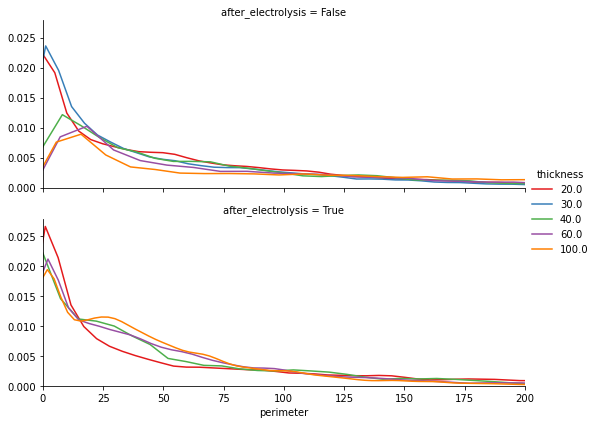

In [680]:
g = sns.FacetGrid(
    roidf, 
    row = 'after_electrolysis',
    palette = 'Set1',
    hue = 'thickness',
    height = 3,
    aspect = 2.5
)

g = g.map(
    sns.kdeplot,
    'perimeter',
    bw = 5,
#     shade = True
#     cut = 0
).add_legend()

plt.xlim((0, 200))



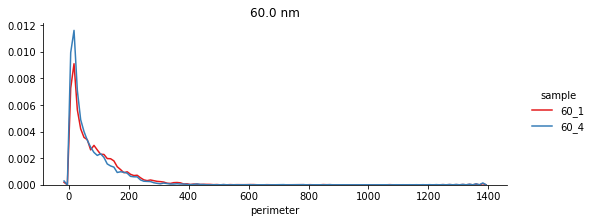

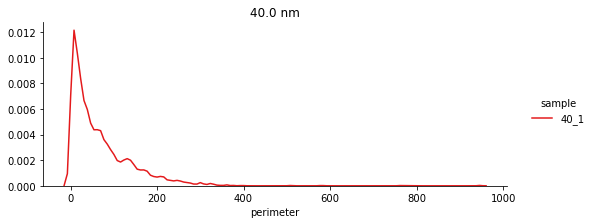

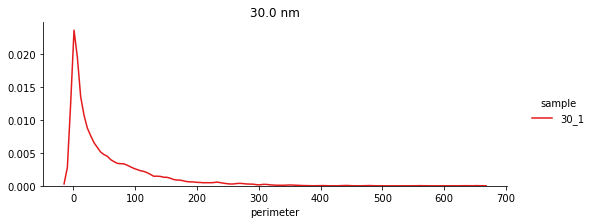

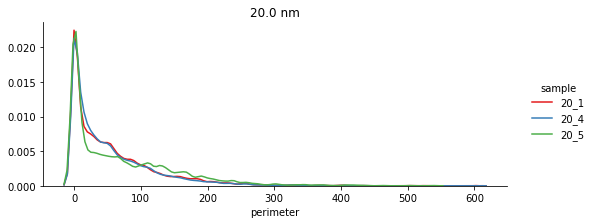

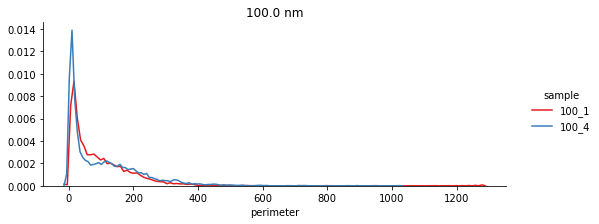

In [683]:
for t in roidf['thickness'].unique():
    dfsel = roidf[
        (roidf['thickness'] == t)
        & (roidf['after_electrolysis'] == False)
    ]
    
    g = sns.FacetGrid(
        dfsel, 
        palette = 'Set1',
        hue = 'sample',
        height = 3,
        aspect = 2.5,
        margin_titles = True
    )

    g = g.map(
        sns.kdeplot,
        'perimeter',
        bw = 5,
    #     shade = True
    #     cut = 0
    ).add_legend()
    
    plt.title('{} nm'.format(t))

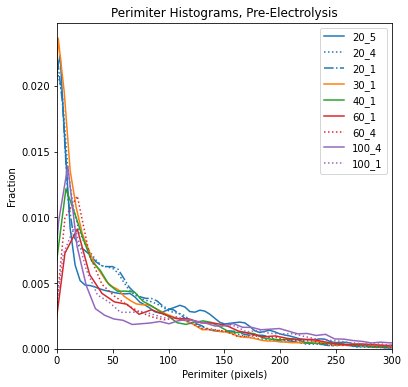

In [711]:
dfsel = roidf[
    (roidf['after_electrolysis'] == False)
]

fig, ax = plt.subplots(1,1,figsize = (6,6))
thicknesses = roidf['thickness'].unique()
thicknesses.sort()

for idx, t in enumerate(thicknesses):
    dfsel = roidf[
        (roidf['after_electrolysis'] == False)
        & (roidf['thickness'] == t)
    ]
    legend = '{} nm'.format(t)
    for s, m in zip(dfsel['sample'].unique(), ['-', ':', '-.', '--']):
        sns.kdeplot(
            dfsel[dfsel['sample'] == s]['perimeter'],
            bw = 5,
            ax = ax,
            color = plt.cm.tab10(idx),
#             legend = False,
            label = s,
            linestyle = m

        )
#         legend = None
    
    plt.xlim((0, 300))
    plt.xlabel('Perimiter (pixels)')
    plt.ylabel('Fraction')
    plt.title('Perimiter Histograms, Pre-Electrolysis')
#     plt.legend()

In [778]:
df = df[df['sample'] != '20_5']

#### Total Perimiter per Sample

In [94]:
def total_perimiter(rois, scale):
    perim = 0
    for r in rois:
        perim += r['perimeter']
    return perim * scale
df['total_perimeter'] = df.apply(lambda x: total_perimiter(x['rois'], x['scale']), axis = 1)

In [95]:
df['area'] = df['extent'].apply(lambda x: x[1]*x[3])

In [96]:
df['perim_density'] = df.apply(lambda r: r['total_perimeter']/r['area'], axis = 1)

In [97]:
dfsel = df[df['mag'] == 1e5]

In [98]:
dfsel['perim_density'].mean()

0.09708915630980011

In [99]:
dfsel['perim_density'].std()*1.98

0.004204866364128146

In [87]:
thicknesses = df['thickness'].unique()
thicknesses.sort()
sampleorder = []
for t in thicknesses:
    dfsel = df[
        (df['after_electrolysis'] == False)
        & (df['thickness'] == t)
    ]
    for s in dfsel['sample'].unique():
        sampleorder.append(s)

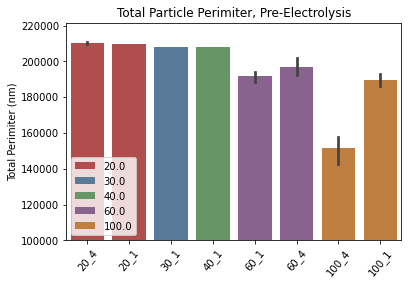

In [785]:
sns.barplot(
    data = df[
        df['after_electrolysis'] == False
    ],
    x = 'sample',
    y = 'total_perimeter',
    hue = 'thickness',
#     hue_order = [20, 30, 40, 60, 100],
    dodge = False,
    order = sampleorder,
    palette = 'Set1',
    saturation = 0.5
)
plt.xticks(rotation = 50)
plt.ylabel('Total Perimiter (nm)')
plt.xlabel(None)
plt.title('Total Particle Perimiter, Pre-Electrolysis')
plt.legend()

Text(0.5, 1.0, '100kx Images')

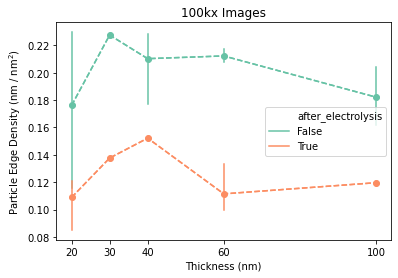

In [96]:
ax = sns.lineplot(
    data = df[df['mag'] != 5e4],
    x = 'thickness',
    y = 'perim_density',
    hue = 'after_electrolysis',
    err_style = 'bars',
    palette = 'Set2'
)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_marker('o')

plt.xlabel('Thickness (nm)')
plt.xticks([20,30,40,60,100])
plt.ylabel('Particle Edge Density (nm / nm$^2$)')
plt.title('100kx Images')

Text(0.5, 1.0, 'Dashed = 100kx Images, Solid = 50kx')

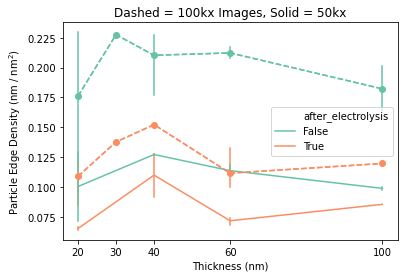

In [99]:
ax = sns.lineplot(
    data = df[df['mag'] != 5e4],
    x = 'thickness',
    y = 'perim_density',
    hue = 'after_electrolysis',
    err_style = 'bars',
    palette = 'Set2'
)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_marker('o')

ax = sns.lineplot(
    data = df[df['mag'] == 5e4],
    x = 'thickness',
    y = 'perim_density',
    hue = 'after_electrolysis',
    err_style = 'bars',
    palette = 'Set2',
    legend = False
)

plt.xlabel('Thickness (nm)')
plt.xticks([20,30,40,60,100])
plt.ylabel('Particle Edge Density (nm / nm$^2$)')
plt.title('100kx Images')
    
plt.xlabel('Thickness (nm)')
plt.xticks([20,30,40,60,100])
plt.ylabel('Particle Edge Density (nm / nm$^2$)')
plt.title('Dashed = 100kx Images, Solid = 50kx')

Text(0, 0.5, 'Particle Edge Density (nm / nm$^2$)')

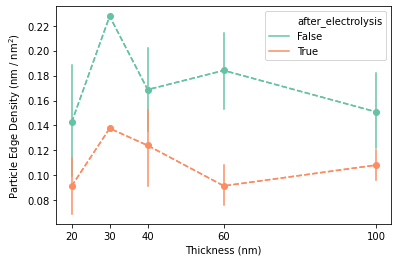

In [95]:
ax = sns.lineplot(
    data = df,
    x = 'thickness',
    y = 'perim_density',
    hue = 'after_electrolysis',
    err_style = 'bars',
    palette = 'Set2'
)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_marker('o')

plt.xlabel('Thickness (nm)')
plt.xticks([20,30,40,60,100])
plt.ylabel('Particle Edge Density (nm / nm$^2$)')

#### Average Area per Sample

In [100]:
def avg_roi_area(rois, scale):
    perim = 0
    for r in rois:
        perim += r['area']*scale*scale
    return perim / len(rois)
df['avg_roi_area'] = df.apply(lambda x: avg_roi_area(x['rois'], x['scale']), axis = 1)

C:\Users\RishiKumar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Dashed = 100kx Images, Solid = 50kx')

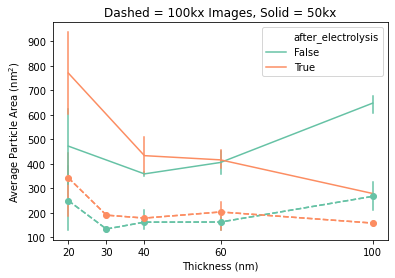

In [101]:
ax = sns.lineplot(
    data = df[df['mag'] != 5e4],
    x = 'thickness',
    y = 'avg_roi_area',
    hue = 'after_electrolysis',
    err_style = 'bars',
    palette = 'Set2'
)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_marker('o')

ax = sns.lineplot(
    data = df[df['mag'] == 5e4],
    x = 'thickness',
    y = 'avg_roi_area',
    hue = 'after_electrolysis',
    err_style = 'bars',
    palette = 'Set2',
    legend = False
)
    
plt.xlabel('Thickness (nm)')
plt.xticks([20,30,40,60,100])
plt.ylabel('Average Particle Area (nm$^2$)')
plt.title('Dashed = 100kx Images, Solid = 50kx')

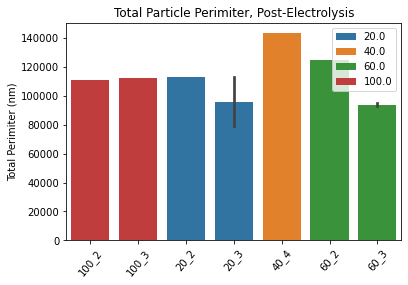

In [750]:
sns.barplot(
    data = df[
        df['after_electrolysis'] == True
    ],
    x = 'sample',
    y = 'total_perimeter',
    hue = 'thickness',
    dodge = False
)
plt.xticks(rotation = 50)
plt.ylabel('Total Perimiter (nm)')
plt.xlabel(None)
plt.title('Total Particle Perimiter, Post-Electrolysis')
plt.legend()

In [103]:
df.columns

Index(['thickness', 'subfolder', 'imgpath', 'scale', 'img',
       'after_electrolysis', 'extent', 'sample', 'rois', 'boundaries', 'mag',
       'total_perimeter', 'area', 'perim_density', 'avg_roi_area'],
      dtype='object')

In [105]:
df_export = df[['thickness', 'sample', 'scale', 'mag', 'after_electrolysis','total_perimeter', 'perim_density', 'area', 'avg_roi_area', 'subfolder', 'imgpath']]

In [106]:
df_export.to_csv('20200407_SEMImageSegmentation.csv')

## Thresholding Development

In [495]:
def getPerimiters(img, rois, sigma = 2, color = [1,1,1,1]):
    perim = np.full(mask.shape, False)
    for r in rois:
#         edgemask = feature.canny(r.intensity_image, sigma = sigma)
        binary_eroded = morphology.erosion(r.filled_image, selem = morphology.disk(sigma))
        edgemask = r.filled_image ^ binary_eroded
        m0, n0, m1, n1 = r.bbox
        perim[m0:m1, n0:n1] += edgemask
    perim[perim > 1] = 1
#     perim[perim == 0] = np.nan
#     perim = perim.astype(np.float32)
    
    colorperim = np.zeros((mask.shape[0], mask.shape[1], 4))
    colorperim[perim] = color
    return colorperim
    

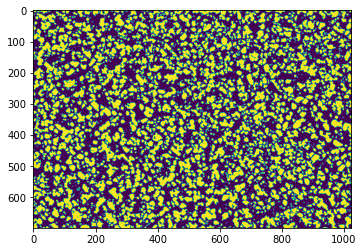

In [496]:
# thresh = filters.threshold_local(d, block_size = 51, offset = 0)
# thresh = filters.threshold_yen(d)
thresh = filters.threshold_niblack(d, window_size = 71, k = 0)
# fig, ax = filters.try_all_threshold(d, figsize = (14,14), verbose = False)
# plt.show()
mask = d > thresh
plt.imshow(mask)

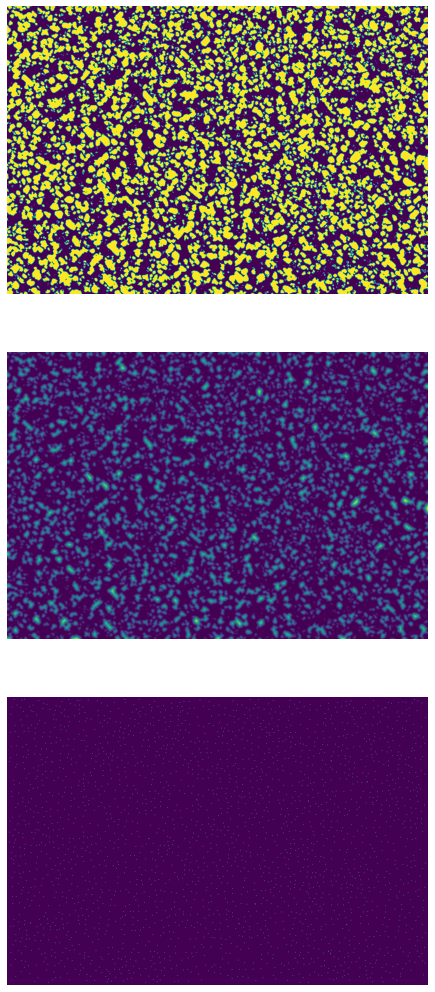

In [497]:
# mark roi centers
# selem = np.asarray([
#     [0,1,0],
#     [1,1,1],
#     [0,1,0]
# ])
# cycles = 3
# for c in range(cycles):
#     mask = morphology.binary_erosion(mask, selem = selem)

distance = ndi.distance_transform_edt(mask)
distance = filters.gaussian(distance, sigma = 1)
# cycles = 5
# for c in range(cycles):
#     distance = morphology.erosion(distance, selem = morphology.disk(1))
local_maxima = feature.peak_local_max(distance, indices = False, footprint = morphology.disk(5), min_distance = 15)#[49:-49, 49:-49]
cycles = 1
# for c in range(cycles):
#     local_maxima = morphology.binary_dilation(local_maxima, selem = morphology.disk(1))
# local_maxima = filters.rank.gradient((d-d.min())/(d.max()-d.min()), morphology.disk(5)) < 12


fig, ax = plt.subplots(3,1, figsize = (12, 18))
ax[0].imshow(mask)
ax[1].imshow(distance)
ax[2].imshow(local_maxima)
lm = local_maxima.astype(np.float32).copy()
lm[lm == 0] = np.nan

ax[0].imshow(lm, cmap = plt.cm.Reds)

for ax_ in ax:
    ax_.axis('off')

In [498]:
#watershed
markers = ndi.label(local_maxima)[0]
roi_labels = segmentation.watershed(-d, markers = markers, mask = mask)
# roi_labels = segmentation.random_walker(mask, markers)

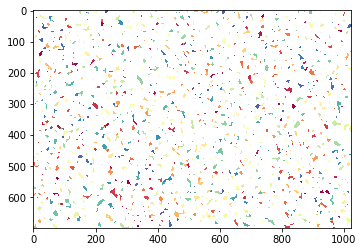

In [499]:
rois_mixed = np.full(roi_labels.shape, np.nan)
for i in np.unique(roi_labels)[1:]:
    rois_mixed[roi_labels == i] = np.random.random()
plt.imshow(rois_mixed, cmap = plt.cm.Spectral)

In [500]:
rois = measure.regionprops(roi_labels, intensity_image = d)

In [501]:
perim = getPerimiters(mask, rois, sigma = 3, color = [1,1,1,0.4])

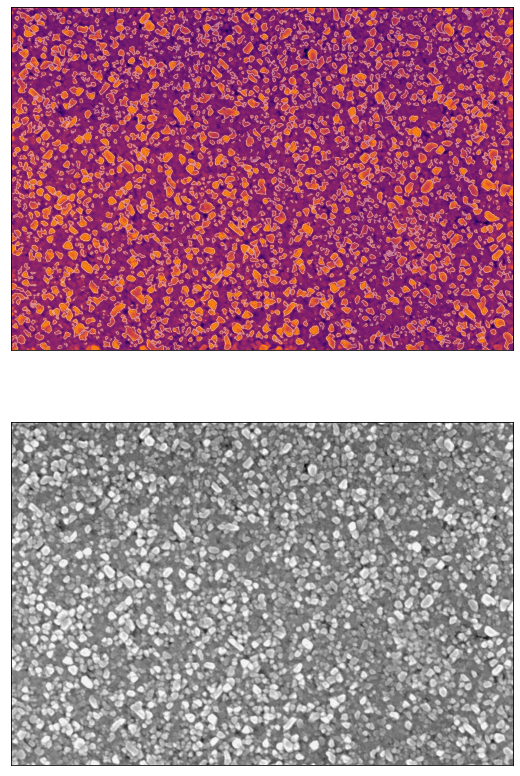

In [506]:
fig, ax = plt.subplots(2,1,figsize = (9,14))
ax[0].imshow(d, extent = extent, vmax = d.max()+2*d.std(), cmap = plt.cm.inferno)
ax[0].imshow(perim, extent = extent)
# ax[0].imshow(mask, extent = extent, cmap = plt.cm.Reds, alpha = 0.1)
ax[1].imshow(d, extent = extent, cmap = plt.cm.gray)
# ax[1].imshow(rois_mixed, extent = extent, cmap = plt.cm.Blues, vmin = -0.5, vmax = 1, alpha = 1)
# ax[1].imshow(mask, extent = extent, alpha = 0.2)
for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])
# plt.colorbar(im, ax = ax, fraction = 0.046)
plt.show()

In [503]:
fill = ndi.binary_fill_holes(edges)

In [109]:
import skimage.filters as filters
import skimage.restoration as restoration
import skimage.feature as feature
import skimage.morphology as morphology
from scipy import ndimage as ndi


def maskWaRD(img, plot = False):

    # thresh = filters.threshold_otsu(img)
    thresh = filters.threshold_local(img,block_size=17, offset=0.0008)
    mask = img <= thresh
    mask = restoration.denoise_tv_chambolle(mask, weight = 0.7, multichannel = False)
    # thresh = filters.threshold_local(mask,block_size=51, offset=0.0008)
    # mask = mask >= thresh

    edgemask = filters.threshold_otsu(mask)
    edges = mask > edgemask
    # edges = feature.canny(mask)
    # edges = filters.sobel(mask)

    # mask[mask <= 0.4] = 0

    # rois = morphology.watershed(mask, markers = edges)
    erosioncycles = 2
    dilationcycles = 2

    rois = edges

    for _ in range(5):
        rois = morphology.binary_dilation(rois, selem = np.array([[0,1,0], [0,1,0], [0,1,0]]))
    for _ in range(5):
        rois = morphology.binary_erosion(rois, selem = np.array([[0,1,0], [0,1,0], [0,1,0]]))

    for _ in range(5):
        rois = morphology.binary_dilation(rois, selem = np.array([[0,0,0], [1,1,1], [0,0,0]]))
    for _ in range(5):
        rois = morphology.binary_erosion(rois, selem = np.array([[0,0,0], [1,1,1], [0,0,0]]))    

    for _ in range(erosioncycles):
        rois = morphology.binary_erosion(rois)#, selem = np.array([[0,1,0], [0,1,0], [0,1,0]]))
    for _ in range(dilationcycles):
        rois = morphology.binary_dilation(rois)#, selem = np.array([[0,1,0], [0,1,0], [0,1,0]]))
    
    totalmask = rois
    
    busbarmask = totalmask
    for _ in range(50):
        busbarmask = morphology.binary_erosion(busbarmask, selem = np.array([[0,1,0], [0,1,0], [0,1,0]]))   
    for _ in range(50):
        busbarmask = morphology.binary_dilation(busbarmask, selem = np.array([[0,1,0], [0,1,0], [0,1,0]]))

    busbarmask[:, :150] = False
    busbarmask[:, -150:] = False
    fingermask = totalmask ^ busbarmask
    

    if plot:
        fig,ax = plt.subplots(1,6)
        ax[0].imshow(img, vmin = 0, vmax = 0.2)
        ax[1].imshow(mask)
        ax[2].imshow(edges)
        ax[3].imshow(rois)
        ax[4].imshow(busbarmask)
        ax[5].imshow(fingermask)
    
    results = {
        'busbar': busbarmask,
        'fingers': fingermask,
        'total': totalmask
    }
    return results

_ = maskWaRD(water, plot = True)


NameError: name 'water' is not defined

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar
import cv2

def findbounds(data, channel, refchannel, molarmass_channel, molarmass_refchannel, tmin = 30, tmax = 200, save = False, boundarysize = 1):
    xrf = data['xrf'][channel][:]
    xrf_ref = data['xrf'][refchannel][:]
    molfrac = (xrf_ref/molarmass_refchannel) / ((xrf_ref/molarmass_refchannel) + (xrf/molarmass_channel))
    scanextent = [data['x'].min(), data['x'].max(), data['y'].min(), data['y'].max()]
    image0 = (xrf).astype(np.uint8)
    ret, thresh = cv2.threshold(image0, tmin, tmax, cv2.THRESH_BINARY)

    kernel = np.ones((2,2), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = boundarysize)
    eroded = cv2.erode(thresh, kernel, iterations = 1)

    fig, ax = plt.subplots(2,2, figsize = (8,8))
    im1 = ax[0,0].imshow(image0, extent = scanextent)
    ax[0,0].set_title('Scan {0}: {1}. ug/cm^2'.format(data['scan'], channel))
    scalebar = ScaleBar(1e-6,
        color = [1, 1, 1, 1],
        box_color = [1, 1, 1],
        box_alpha = 0,
        location = 'lower right',
        border_pad = 0.1)
    ax[0,0].add_artist(scalebar)
    fig.colorbar(im1, ax = ax[0,0])
    im2 = ax[0,1].imshow(xrf_ref, extent = scanextent)
    ax[0,1].set_title('Scan {0}: {1}. ug/cm^2'.format(data['scan'], refchannel))
    scalebar = ScaleBar(1e-6,
        color = [1, 1, 1, 1],
        box_color = [1, 1, 1],
        box_alpha = 0,
        location = 'lower right',
        border_pad = 0.1)
    ax[0,1].add_artist(scalebar)
    fig.colorbar(im2, ax = ax[0,1])
    im3 = ax[1,0].imshow(xrf, extent = scanextent, cmap = plt.cm.gray)
    insidealpha = np.ma.masked_where(eroded == 0, eroded)
    boundariesalpha = np.ma.masked_where(dilated - eroded == 0, dilated - eroded)
    ax[1,0].imshow(insidealpha, extent = scanextent, cmap = plt.cm.RdYlBu, interpolation = None, alpha = 0.5)
    ax[1,0].imshow(boundariesalpha, extent = scanextent, cmap = plt.cm.coolwarm, alpha = 0.5)
    scalebar = ScaleBar(1e-6,
            color = [1, 1, 1, 1],
            box_color = [1, 1, 1],
            box_alpha = 0,
            location = 'lower right',
            border_pad = 0.1)
    ax[1,0].add_artist(scalebar)
    ax[1,0].set_title('Regions')

    im4 = ax[1,1].imshow(molfrac, extent = scanextent, cmap = plt.cm.inferno)
    ax[1,1].set_title('{0}/{1}+{0}'.format(refchannel, channel))
    fig.colorbar(im4, ax = ax[1,1])
    scalebar = ScaleBar(1e-6,
        color = [1, 1, 1, 1],
        box_color = [1, 1, 1],
        box_alpha = 0,
        location = 'lower right',
        border_pad = 0.1)
    ax[1,1].add_artist(scalebar)    
#     plt.tight_layout()
    
    for hax in ax.ravel():
        hax.axis('off')
    inside = np.array(eroded, dtype = bool)
    boundaries = np.array(dilated-eroded, dtype = bool)
    
    if save:
        path = os.path.join(save, '{0}_PbBaBoundaries'.format(data['scan']))
        plt.savefig(path, bbox_inches = 'tight')
    return inside, boundaries